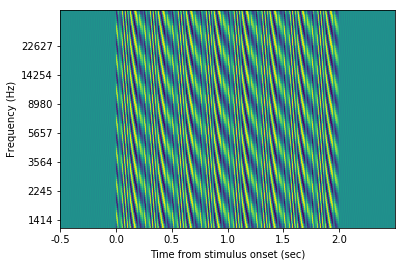

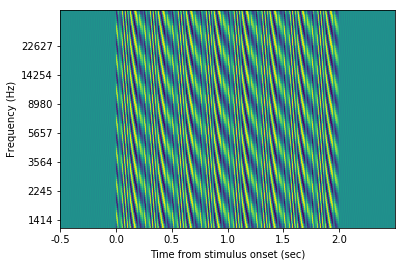

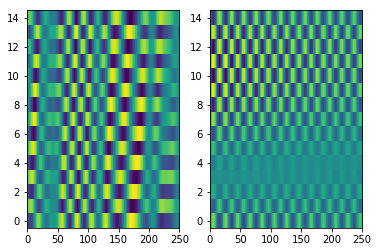

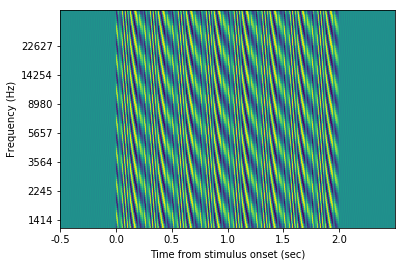

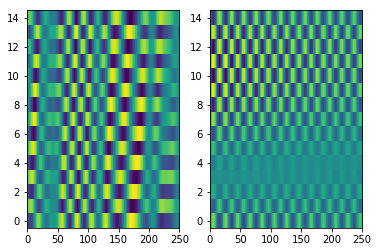

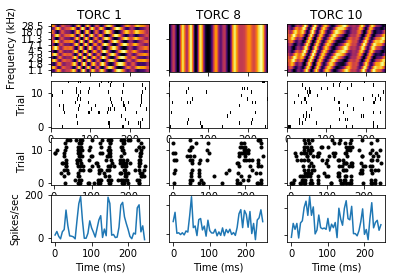

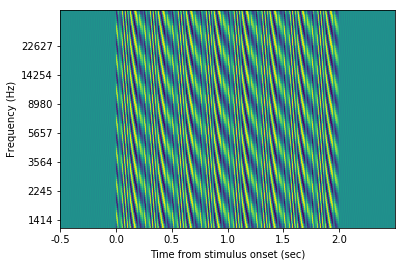

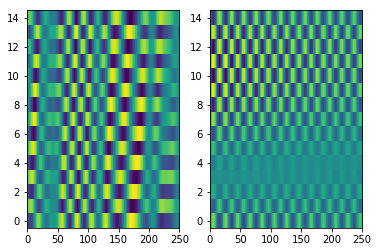

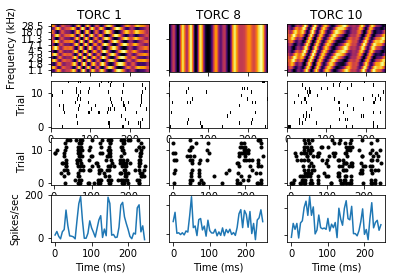

starting CD: n_params=165, step size: 0.100000 tolerance: 0.000100
1: Backwards (delta=-0.0153549564724), adjusting step size to 0.05
2: best step=28,0 error=0.915455000249, delta=0.0998999562233
3: best step=26,1 error=0.892279279183, delta=0.0231757210661
4: Backwards (delta=-0.00822011440937), adjusting step size to 0.025
5: best step=27,0 error=0.873333716891, delta=0.0271656767015
6: best step=26,0 error=0.862672625288, delta=0.0106610916027
7: best step=29,1 error=0.854036882037, delta=0.00863574325087
8: best step=43,0 error=0.845024697346, delta=0.00901218469144
9: Backwards (delta=-0.00100562268605), adjusting step size to 0.0125
10: best step=88,1 error=0.839763603815, delta=0.00626671621722
11: best step=58,1 error=0.836883058509, delta=0.00288054530606
12: best step=73,1 error=0.833729426074, delta=0.00315363243481
13: best step=43,1 error=0.831069657252, delta=0.00265976882211
14: best step=42,1 error=0.828707795604, delta=0.00236186164791
15: best step=29,0 error=0.827558

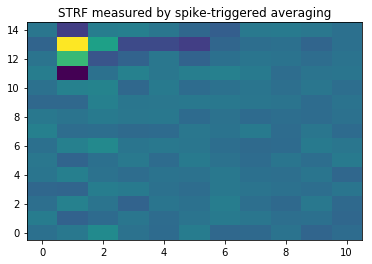

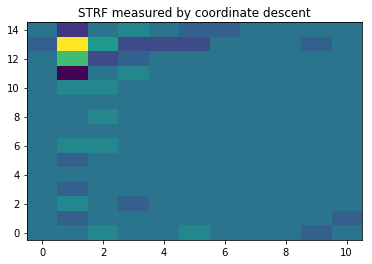

In [1]:
# Python class -- WEEK 5
#
# Processing spiking data recorded during presentation of temporally
# orthogonal ripple combinations (TORCs). TORCs are stimulus designed
# for efficient white noise analysis of the auditory system. The basic
# idea is to play a lot of complex random sounds while recording the
# activity of an auditory neuron. You then find the average sound that
# evokes an increase in spiking activity
#
# Goals: 
# 1. Deal with some very practical resampling and reshaping problems. 
# 2. Visualize TORC stimulus spectrograms
# 3. Plot spike raster, showing the time of spike events aligned in
#    time to the spectrogram
# 4. Plot peristimulus time histogram (PSTH) response to the TORCs,
#    i.e., the time-varying firing rate averaged across presentations
#    of the TORC stimulus.

import numpy as np
import pylab as plt

import scipy.io
import scipy.signal

import strflib

# The data: 

# Spike data were recorded from a single neuron in primary auditory
# cortex during 2 repetitions of 30 different TORC stimuli, each 2
# seconds long and with 0.5 sec of silence before and after the
# sound. These TORCs consist of the same spectro-temporal pattern
# repeated 4 times a second. So each 2-sec stimulus effectively
# contains cycles of the same sound. The first cycle drives onset
# transients, so usually it is discarded, leaving 7 cycles of
# "steady-state" stimuluation on each trial.

# load contents of Matlab data file
#filepath="data/tor_data_btn026d-a1.mat"
filepath="data/tor_data_por073b-b1.mat"

data = strflib.load_torc_data(filepath)

# parse into relevant variables
# spectrogram of TORC stimuli. 15 frequency bins X 300 time samples X 30 different TORCs
stim=data['stim']
FrequencyBins=data['FrequencyBins']
stimFs=data['stimFs']
StimCyclesPerSec=data['StimCyclesPerSec']

# response matrix. sampled at 1kHz. value of 1 means a spike occured
# in a particular time bin. 0 means no spike. shape: [3000 time bins X 2
# repetitions X 30 different TORCs]

resp=data['resp']

# each trial is (PreStimSilence + Duration + PostStimSilence) sec long
Duration=data['Duration']
PreStimSilence=data['PreStimSilence']
respFs=data['respFs']
PostStimSilence=data['PostStimSilence']





# 1. Because the fastest stimulus modulations were 50Hz, the stimulus
# was be stored at low resolution to save space (100 Hz). However, to
# align with the response (stored at 1000 Hz), we need to resample the
# stimulus.  Use the scipy.signal.resample() command to resample the
# temporal axis of the stimulus spectrogram from 100 Hz to 1000 Hz

stim1K=scipy.signal.resample(stim,int(stim.shape[1]*respFs/stimFs),axis=1)


# 2. display the stimulus spectrogram from an entire single trial,
# label time and frequency axes appropriately

plt.close("all")

trialidx=0

plt.figure()
exampleSG=scipy.signal.resample(stim1K[:,:,trialidx],120,axis=0)
plt.imshow(exampleSG, interpolation='nearest', aspect='auto',origin='lower')
ax=plt.gca()
yt=np.arange(1,15,2)
ax.set_yticks(yt*8-4)
ax.set_yticklabels(FrequencyBins[yt.astype(int)])
ax.set_ylabel('Frequency (Hz)')

xt=np.arange(0,stim1K.shape[1],500,dtype=float)
ax.set_xticks(xt)
ax.set_xticklabels(xt/respFs-PreStimSilence)
ax.set_xlabel('Time from stimulus onset (sec)')

plt.show(False)


# 3. snip out the first and second cycles of the stimulus (ie, 250-ms
# segements) to convince yourself that the stimulus is infact
# repeating.  save a 250-ms snip from each trial for alignment with
# the response. so the resulting excised stimulus should have shape :
# [15 spectral channels X 250 1ms samples X 30 TORCs]

cycleduration=1.0/StimCyclesPerSec
cyclebins=np.round(cycleduration*respFs).astype(int)
PreBins=np.round(PreStimSilence*respFs).astype(int)

stim0=stim1K[:,(PreBins+cyclebins):(PreBins+cyclebins*2),:]
snip1=stim0[:,:,trialidx]
snip2=stim1K[:,(PreBins+cyclebins*2):(PreBins+cyclebins*3),trialidx]

plt.figure()
ax=plt.subplot(1,2,1);
ax.imshow(snip1, interpolation='nearest', aspect='auto',origin='lower')
ax=plt.subplot(1,2,2);
ax.imshow(snip2-snip1, interpolation='nearest', aspect='auto',origin='lower')

plt.show(False)



# 4. trim the first 0.75 sec and last 0.5 sec from the response matrix
# to remove the silent periods and then reshape so that the remaining
# 7 cycles per trial are treated as repetitions. a great opportunity
# to use the reshape command with the -1 option! now the response
# should be shape: [250 time samples X 14 reps X 30 TORCs]

pretrimbins=np.round((PreStimSilence+cycleduration)*respFs).astype(int)
posttrimbins=np.round(PostStimSilence*respFs).astype(int)
stimcount=resp.shape[2]

resp0=resp[pretrimbins:-posttrimbins,:,:].T
resp0=resp0.reshape(stimcount,-1,cyclebins).T


# 5. plot spectrogram aligned with the raster for a few different
# TORCs (I recommend TORC 0, 7, & 9). 
# inelegant approach: display the raster using imshow. 
# elegant approach: find spike times and use the plot command to 
# display points for each spike event

# 6. average the rasters across trials and downsample by a factor of 5 to
# plot the PSTH for each TORC response

plt.figure()
trialset=np.array((0,7,9))
N=trialset.shape[0]

# fh,ax=plt.subplots(4,N)
for ii in range(0,N):
    trialidx=trialset[ii]
    
    ax=plt.subplot(4,N,ii+1)
	# for ax[0,ii].imshow....
    ax.imshow(stim0[:,:,trialidx], interpolation='nearest', aspect='auto',origin='lower', cmap='inferno')
    ax.set_title('TORC {0}'.format(trialidx+1))
    if ii==0:
        yt=np.arange(0,15,2)
        ax.set_yticks(yt)
        ax.set_yticklabels(np.round(FrequencyBins[yt.astype(int)].astype(float)/1000,decimals=1))
        ax.set_ylabel('Frequency (kHz)')
    else:
        ax.set_yticklabels([])
        
    ax.set_xticklabels([])

    ax=plt.subplot(4,N,ii+N+1)
    ax.imshow(1-resp0[:,:,trialidx].T, interpolation='nearest', aspect='auto',origin='lower',cmap='gray')
    if ii==0:
        ax.set_ylabel('Trial')
    else:
        ax.set_yticklabels([])
     
    ax=plt.subplot(4,N,ii+N*2+1)
    [spikebin,spiketrial]=np.array(np.nonzero(resp0[:,:,trialidx]),dtype=float)
    spiketime=spikebin/respFs*1000
    ax.plot(spiketime,spiketrial,'k.')
    if ii==0:
        ax.set_ylabel('Trial')
    else:
        ax.set_yticklabels([])
    
    ax=plt.subplot(4,N,ii+N*3+1)
    psth=np.mean(resp0[:,:,trialidx],axis=1)*respFs
    psth=scipy.signal.resample(psth,int(psth.shape[0]/5))
    t=np.arange(0,psth.shape[0],dtype=float)/respFs*5*1000
    
    ax.plot(t,psth)
    if ii==0:
        ax.set_ylabel('Spikes/sec')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('Time (ms)')
    
plt.show(False)
#lt.tight_layout()

plt.show()



# 7. STRF estimation
psth=np.mean(resp,axis=1)
psth=scipy.signal.resample(psth,stim.shape[1])

X=np.reshape(stim,[stim.shape[0],-1],order='F')
Y=np.reshape(psth,[1,-1],order='F')
Y=Y-np.mean(Y)


(Hsta,Hsta0)=strflib.sta(X,Y,10)
plt.figure()
plt.imshow(Hsta, origin='lower', aspect='auto')
plt.title('STRF measured by spike-triggered averaging')


(Hcd,Hcd0)=strflib.coordinate_descent(X,Y,10)
plt.figure()
plt.imshow(Hcd, origin='lower', aspect='auto')
plt.title('STRF measured by coordinate descent')

plt.show()


# some exercises:

# 1. generate and overlay the prediciton of the STRF(s) on the actual PSTHs
# 2. compute the spectral modulation tuning using np.fft or a related function, 
#    like fft2